# Team, Skoltech project for implementing async method of optimization in neural networks:
Denis Boborukhin,
Dmitriy Kosenkov,
Alexander Marukhin,

Вот пример работы `Executor.submit`, который позволяет бить на пулы выполнение задачи.
Подробнее о concurrent.futures: [Хабр о конкуррентах и фьючерсах](https://habr.com/ru/companies/otus/articles/771346/)

Главное, что нам дает:


1.   Выполняется параллельно и не надо париться насчет питонячьего GIL
2.   Может выполняться также и асинхронно на более серьезных задачах
3.   `submit` метод ниже работает вот так: мы ему дали задачи, он нам выдал взамен future. выполнение `future.result()` происходит только тогда, когда задача на данном потоке выполнена.



In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [2]:
# Generate a synthetic finite-sum least squares regression dataset
n = 2000   # number of samples
d = 20     # dimension
noise_std = 0.1

# True parameter
w_true = np.random.randn(d)

# Features
X = np.random.randn(n, d)

# Targets with Gaussian noise
y = X @ w_true + noise_std * np.random.randn(n)

print("Data shape X:", X.shape, "y:", y.shape)

# Define individual loss and its gradient
def f_i(w, i):
    """Loss for sample i: 0.5 * (y_i - x_i^T w)^2."""
    r = y[i] - X[i] @ w
    return 0.5 * r**2

def grad_f_i(w, i):
    """Gradient of f_i with respect to w."""
    r = y[i] - X[i] @ w
    return -r * X[i]

def f_full(w):
    """Full objective: average of f_i."""
    residuals = y - X @ w
    return 0.5 * np.mean(residuals**2)

def grad_f_full(w):
    """Full gradient: average of gradients."""
    residuals = y - X @ w
    return -(X.T @ residuals) / n

Data shape X: (2000, 20) y: (2000,)


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:13: RuntimeWarning: divide by zero encountered in matmul
  y = X @ w_true + noise_std * np.random.randn(n)
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:13: RuntimeWarning: overflow encountered in matmul
  y = X @ w_true + noise_std * np.random.randn(n)
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:13: RuntimeWarning: invalid value encountered in matmul
  y = X @ w_true + noise_std * np.random.randn(n)


## Rennala Implementation

In [3]:
def rennala(x0, gamma=0.01, S=32, K=100, workers=4):
    x = x0.copy()
    hist, losses = [x.copy()],[]

    with ThreadPoolExecutor(workers) as ex:
        for k in range(K):
            futures, g, s = [], np.zeros_like(x), 0

            for _ in range(min(S,workers)):
                futures.append(ex.submit(grad_f_i, x, np.random.randint(n)))

            for f in as_completed(futures):
                g += f.result() / S
                s += 1
                if s < S:
                    futures.append(ex.submit(grad_f_i, x, np.random.randint(n)))
                if s >= S:
                    for f_ in futures: f_.cancel()
                    break

            x = x - gamma * g
            hist.append(x.copy())
            losses.append(f_full(x))

    return x, hist, losses

## RingMaster ASGD Implementation

In [34]:
def ringmaster_asgd(x0, gamma=0.01, R=5, K=1000, workers=4):
    x = x0.copy()
    history = [x.copy()]
    losses = []
    
    pending_futures = {}
    iteration_counter = 0
    
    async_gamma = gamma / (1 + R/2)
    print(f"Using step size: {async_gamma:.6f} (base: {gamma:.6f}, R={R})")
    
    with ThreadPoolExecutor(max_workers=workers) as executor:
        for _ in range(min(workers, K)):
            future = executor.submit(grad_f_i, x, np.random.randint(n))
            pending_futures[future] = (iteration_counter, x.copy())
        
        while iteration_counter < K and pending_futures:
            future = next(as_completed(pending_futures.keys()))
            
            grad = future.result()
            iteration_started, x_at_start = pending_futures[future]
            delay = iteration_counter - iteration_started
            
            # Remove this future from pending
            del pending_futures[future]
            
            if delay < R:
                x = x - async_gamma * grad
                iteration_counter += 1
                
                history.append(x.copy())
                current_loss = f_full(x)
                losses.append(current_loss)
                
                # if iteration_counter % 50 == 0:
                #     print(f"Iter {iteration_counter}: delay={delay}, loss={current_loss:.6f}")
            else: # Ignore the outdated gradient
                # if iteration_counter % 50 == 0:
                #     print(f"Iter {iteration_counter}: Ignored gradient with delay {delay} (>= R={R})")
                pass
            
            if len(pending_futures) < min(workers, K - iteration_counter):
                new_future = executor.submit(grad_f_i, x, np.random.randint(n))
                pending_futures[new_future] = (iteration_counter, x.copy())
    
    print(f"Completed {iteration_counter} iterations")
    return x, history, losses

## Calculate Lipschitz Constant

In [12]:
def L_num(X, y, num_samples=1000):
    max_ratio = 0
    n_samples = X.shape[0]

    for _ in range(num_samples):
        w1 = np.random.randn(d)
        w2 = np.random.randn(d) + 1e-6  # a lil noise
        # precomp grads
        grad1 = X.T @ (X @ w1 - y) / n
        grad2 = X.T @ (X @ w2 - y) / n
        grad_d= np.linalg.norm(grad1 - grad2)
        w_d = np.linalg.norm(w1 - w2)

        if w_d > 1e-10:
            ratio = grad_d/w_d
            max_ratio = max(max_ratio, ratio)

    return max_ratio

L = L_num(X, y, num_samples=500)

gamma_sync = 1.0 / L

gamma_async_base = gamma_sync * 0.1

/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/1085779122.py:9: RuntimeWarning: divide by zero encountered in matmul
  grad1 = X.T @ (X @ w1 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/1085779122.py:9: RuntimeWarning: overflow encountered in matmul
  grad1 = X.T @ (X @ w1 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/1085779122.py:9: RuntimeWarning: invalid value encountered in matmul
  grad1 = X.T @ (X @ w1 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/1085779122.py:10: RuntimeWarning: divide by zero encountered in matmul
  grad2 = X.T @ (X @ w2 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/1085779122.py:10: RuntimeWarning: overflow encountered in matmul
  grad2 = X.T @ (X @ w2 - y) / n
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/1085779122.py:10: RuntimeWarning: invalid value encountered in matmul
  grad2 = X.T @ (X @ w2 - y) / n


## Test Rennala

In [23]:
print("Testing Rennala (synchronous)")
x0 = np.zeros(d)

print(f"Initial loss: {f_full(x0):.6f}")

start = time.perf_counter()
w_rennala, hist_rennala, losses_rennala = rennala(x0, gamma=gamma_sync, K=500, workers=4)
duration_rennala = time.perf_counter() - start

print(f"Rennala completed in {duration_rennala:.4f} seconds")
print(f"Final loss: {losses_rennala[-1]:.6f}")
print(f"Loss reduction: {losses_rennala[0] - losses_rennala[-1]:.6f}")

Testing Rennala (synchronous)
Initial loss: 9.043957
Rennala completed in 0.0871 seconds
Final loss: 0.007601
Loss reduction: 5.500456


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:30: RuntimeWarning: divide by zero encountered in matmul
  residuals = y - X @ w
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:30: RuntimeWarning: overflow encountered in matmul
  residuals = y - X @ w
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:30: RuntimeWarning: invalid value encountered in matmul
  residuals = y - X @ w


## Test RingMaster ASGD

In [35]:
x0 = np.zeros(d)

R_values = [1, 3, 10]
results = {}

for R in R_values:
    print(f"RingMaster: R = {R}")
    
    gamma = gamma_async_base
    start = time.perf_counter()
    w_rm, hist_rm, losses_rm = ringmaster_asgd(x0, gamma=gamma, R=R, K=500, workers=4)
    duration = time.perf_counter() - start
    
    print(f"Completed in {duration:.4f} seconds")
    print(f"Final loss: {losses_rm[-1]:.6f}")
    print(f"Loss reduction: {losses_rm[0] - losses_rm[-1]:.6f}")

    results[R] = {
        'losses': losses_rm,
        'duration': duration,
        'final_loss': losses_rm[-1]
    }

RingMaster: R = 1
Using step size: 0.061198 (base: 0.091797, R=1)
Completed 500 iterations
Completed in 0.0620 seconds
Final loss: 0.011532
Loss reduction: 8.957645
RingMaster: R = 3
Using step size: 0.036719 (base: 0.091797, R=3)
Completed 500 iterations
Completed in 0.0213 seconds
Final loss: 0.007599
Loss reduction: 8.562194
RingMaster: R = 10
Using step size: 0.015299 (base: 0.091797, R=10)
Completed 500 iterations
Completed in 0.0192 seconds
Final loss: 0.005927
Loss reduction: 9.040218


/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:30: RuntimeWarning: divide by zero encountered in matmul
  residuals = y - X @ w
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:30: RuntimeWarning: overflow encountered in matmul
  residuals = y - X @ w
/var/folders/vy/zh7cb8rn603gh5vpx6rjfhv40000gn/T/ipykernel_42135/2562395776.py:30: RuntimeWarning: invalid value encountered in matmul
  residuals = y - X @ w


## Visualization

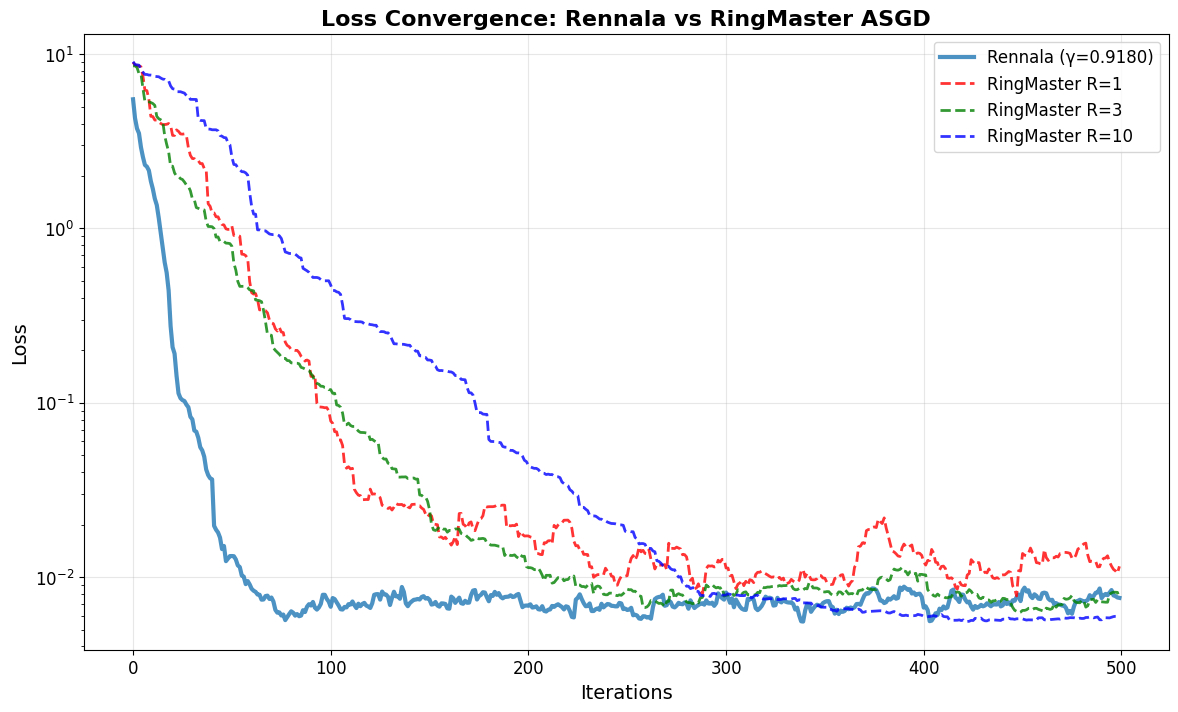

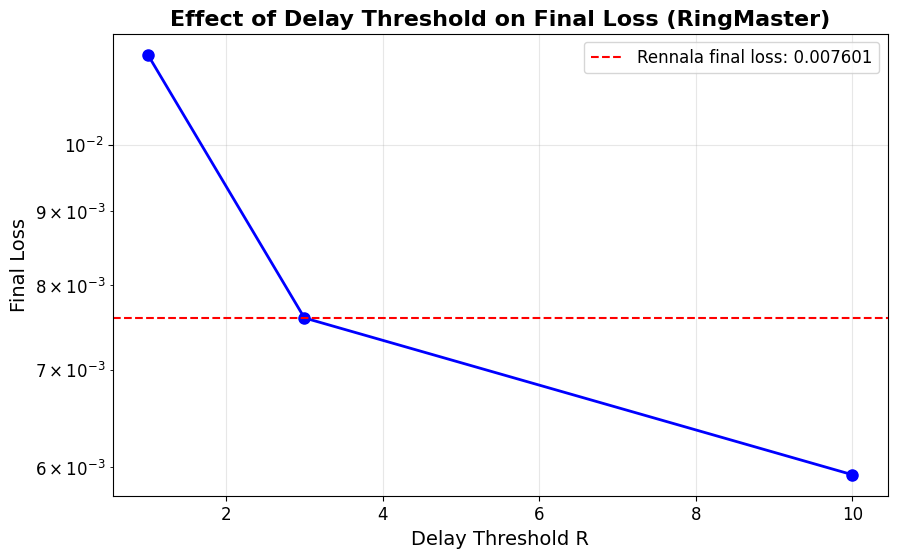

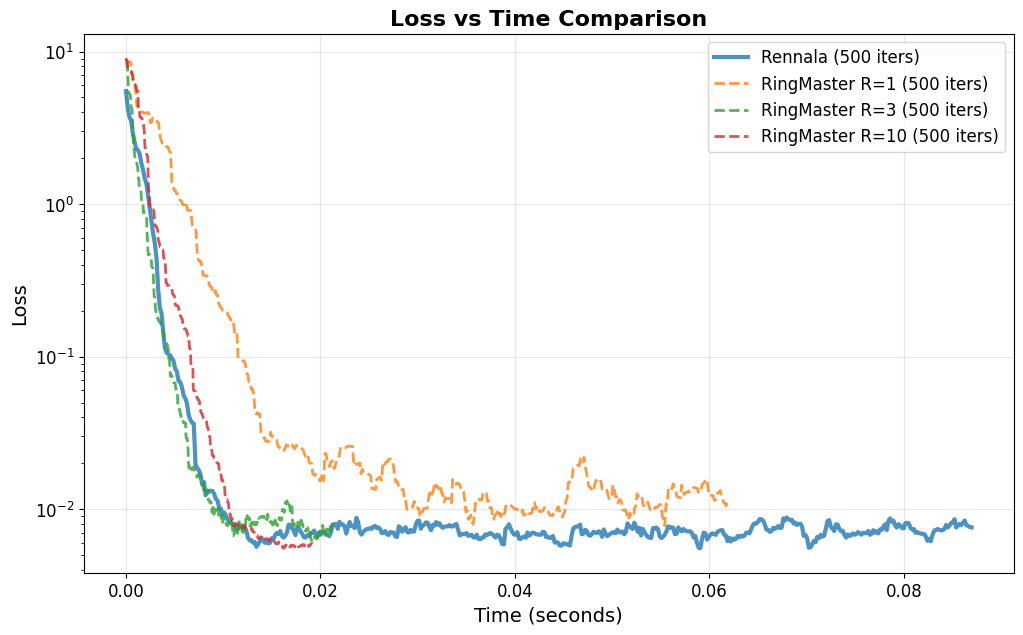

In [36]:
plt.figure(figsize=(14, 8))

plt.plot(range(len(losses_rennala)), losses_rennala, 
            label=f'Rennala (γ={gamma_sync:.4f})', 
            linewidth=3, alpha=0.8)

colors = ['red', 'green', 'blue', 'purple']
for idx, (R, res) in enumerate(results.items()):
    if res['losses']:
        plt.plot(range(len(res['losses'])), res['losses'], 
                 label=f'RingMaster R={R}', 
                 color=colors[idx % len(colors)], 
                 linewidth=2, linestyle='--', alpha=0.8)

plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Convergence: Rennala vs RingMaster ASGD', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

plt.figure(figsize=(10, 6))

R_list = sorted(results.keys())
final_losses = [results[R]['final_loss'] for R in R_list]

plt.plot(R_list, final_losses, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Delay Threshold R', fontsize=14)
plt.ylabel('Final Loss', fontsize=14)
plt.title('Effect of Delay Threshold on Final Loss (RingMaster)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.axhline(y=losses_rennala[-1], color='red', linestyle='--', 
            label=f'Rennala final loss: {losses_rennala[-1]:.6f}')
plt.legend(fontsize=12)

plt.show()

plt.figure(figsize=(12, 7))

time_per_iter_rennala = duration_rennala / len(losses_rennala)
time_rennala = [i * time_per_iter_rennala for i in range(len(losses_rennala))]
plt.plot(time_rennala, losses_rennala, 
            label=f'Rennala ({len(losses_rennala)} iters)', 
            linewidth=3, alpha=0.8)

for R in R_values:
    if R in results and results[R]['losses']:
        time_per_iter = results[R]['duration'] / len(results[R]['losses'])
        time_rm = [i * time_per_iter for i in range(len(results[R]['losses']))]
        plt.plot(time_rm, results[R]['losses'], 
                 label=f'RingMaster R={R} ({len(results[R]["losses"])} iters)', 
                 linewidth=2, linestyle='--', alpha=0.8)

plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss vs Time Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Analysis

In [9]:
print("=== Analysis ===")
print(f"\nProblem characteristics:")
print(f"- Dataset size: n={n}, d={d}")
print(f"- Lipschitz constant L ≈ {L:.4f}")
print(f"- Safe step size for sync: γ = 1/L ≈ {gamma_sync:.6f}")

print(f"\nRennala (synchronous mini-batch):")
if losses_rennala:
    print(f"- Final loss: {losses_rennala[-1]:.6f}")
    print(f"- Time: {duration_rennala:.4f} seconds")
    print(f"- Iterations per second: {len(losses_rennala)/duration_rennala:.2f}")

print(f"\nRingMaster ASGD observations:")
print("1. Step size scaling: Async methods need smaller step sizes.")
print("   We used γ_async = γ_sync / 10 = {:.6f}".format(gamma_async_base))
print("2. R parameter controls staleness tolerance:")
print("   - Small R (R=1): Only fresh gradients, more wasted computation")
print("   - Moderate R (R=3-5): Good balance")
print("   - Large R (R=10): Uses very stale gradients, may harm convergence")

print(f"\nTrade-offs:")
print("- Rennala: Synchronous, stable, but workers wait for each other")
print("- RingMaster: Asynchronous, better CPU utilization, but needs careful tuning")
print("  (smaller step size, appropriate R)")

# Show best RingMaster result
if results:
    best_R = min(results.keys(), key=lambda R: results[R]['final_loss'])
    best_loss = results[best_R]['final_loss']
    print(f"\nBest RingMaster result: R={best_R} with loss={best_loss:.6f}")
    
    if losses_rennala:
        if best_loss < losses_rennala[-1]:
            print("RingMaster achieved better loss than Rennala!")
        else:
            print("Rennala achieved better loss than RingMaster.")

=== Analysis ===

Problem characteristics:
- Dataset size: n=2000, d=20
- Lipschitz constant L ≈ 1.0839
- Safe step size for sync: γ = 1/L ≈ 0.922591

Rennala (synchronous mini-batch):
- Final loss: 0.006741
- Time: 0.0117 seconds
- Iterations per second: 8564.61

RingMaster ASGD observations:
1. Step size scaling: Async methods need smaller step sizes.
   We used γ_async = γ_sync / 10 = 0.092259
2. R parameter controls staleness tolerance:
   - Small R (R=1): Only fresh gradients, more wasted computation
   - Moderate R (R=3-5): Good balance
   - Large R (R=10): Uses very stale gradients, may harm convergence

Trade-offs:
- Rennala: Synchronous, stable, but workers wait for each other
- RingMaster: Asynchronous, better CPU utilization, but needs careful tuning
  (smaller step size, appropriate R)

Best RingMaster result: R=5 with loss=0.110427
Rennala achieved better loss than RingMaster.


## Extra: Effect of Step Size

In [10]:
# Test different step sizes for RingMaster
print("\n=== Testing Different Step Sizes for RingMaster (R=3) ===")

R_test = 3
step_sizes = [gamma_async_base * 0.5, gamma_async_base, gamma_async_base * 2]
step_results = {}

for step_size in step_sizes:
    print(f"\nTesting step size: {step_size:.6f}")
    x0_test = np.zeros(d)
    
    start = time.perf_counter()
    w_test, hist_test, losses_test = ringmaster_asgd(x0_test, gamma=step_size, R=R_test, K=80, workers=4)
    duration = time.perf_counter() - start
    
    if losses_test:
        print(f"Final loss: {losses_test[-1]:.6f}")
        print(f"Converged: {"Yes" if losses_test[-1] < losses_test[0] * 0.9 else "No"}")
        step_results[step_size] = losses_test

# Plot step size comparison
if step_results:
    plt.figure(figsize=(12, 7))
    
    for step_size, losses in step_results.items():
        plt.plot(range(len(losses)), losses, 
                 label=f"γ={step_size:.6f}", 
                 linewidth=2)
    
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(f'Effect of Step Size on RingMaster Convergence (R={R_test})', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()
    
    print("\nStep size findings:")
    print("- Too large: May diverge or oscillate")
    print("- Too small: Slow convergence")
    print("- Just right: Good balance of stability and speed")

SyntaxError: f-string: expecting '}' (2490543191.py, line 18)